## Кредитный Скоринг

https://www.kaggle.com/c/fintech-credit-scoring

**В качестве итоговой модели был выбран Грдиентный бустинг, оценка roc-auc на тесте kaggle составила: 0.71826**

#### Описание задачи
Дана выборка заявок на кредитный продукт. Про заявителей известны различные данные на момент заполнения анкеты. По части выборки (train, validate) известны результаты пользования кредитом (случился дефолт или нет), а по другой части(test) результаты известны только организаторам. Необходимо извлечь зависимость из имеющихся данных о заявителях и фактом наличия дефолта, и предсказать результат на тестовых данных.
В качестве метрики используется AUC

## Оглавление:<a class='anchor' id='0'></a>
1. [Предобработка данных:](#1)
2. [Разбивка и подготовка данных](#2)
3. [Создание конвеера и обучение моделей](#3)
4. [Подбор параметров и анализ качества градиентного бустинга](#4)
5. [Ансамблирование алгоритмов посредством стекинга](#5)
6. [Сравнение ROC кривых](#6)
7. [Получение прогнозов](#7)
8. [Пользовательские функции](#8)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn
from sklearn.utils import shuffle
from matplotlib import pylab as plt
%matplotlib inline

### 1. Предобработка данных <a class='anchor' id='1'></a>
[в начало](#0)

**Подгрузка данных**

In [2]:
data = pd.read_csv('application_info.csv') # подрузим выборки
label = pd.read_csv('default_flg.csv') # подргузим целевые метки

In [3]:
data.head()

,id,application_dt,sample_cd,education_cd,gender_cd,age,car_own_flg,car_type_flg,appl_rej_cnt,good_work_flg,Score_bki,out_request_cnt,region_rating,home_address_cd,work_address_cd,income,SNA,first_time_cd,Air_flg
0,1,01JAN2014,train,SCH,M,27,Y,Y,0,0,-1.917831,0,40,2,3,32000,1,4,N
1,2,01JAN2014,train,GRD,F,26,N,N,0,0,-1.153144,2,60,2,3,50000,2,1,N
2,3,01JAN2014,train,SCH,M,35,N,N,0,1,-1.732810,0,40,1,2,20000,4,3,N
3,4,01JAN2014,train,GRD,F,35,N,N,0,1,-2.552133,2,20,2,3,80000,1,3,N
4,5,01JAN2014,train,UGR,F,24,N,N,0,0,-1.914581,1,50,2,3,27000,1,2,N


In [4]:
# label.head() # целевые метки

**Описание признаков:**
- id - Анонимизированный идентификатор заявителя
- application_dt - Дата подачи заявки
- sample_cd - Категория выборки
- education_cd - Образование
- gender_cd - Пол
- age - Возраст
- car_own_flg - Флаг наличия автомобиля
- car_type_flg - Флаг наличия иномарки
- appl_rej_cnt - Количество отказанных прошлых заявок
- good_work_flg - Флаг наличия "хорошей" работы
- Score_bki - Скор балл по данным из бюро кредитных историй
- out_request_cnt - Количество запросов в бюро
- region_rating - Рейтинг региона
- home_address_cd - Категоризатор домашнего адреса
- work_address_cd - Категоризатор рабочего адреса
- income - Доход заявителя
- SNA - Связь заявителя с клиентами
- first_time_cd - Давность наличия информации о заявителе
- Air_flg - Наличие загран паспорта
- default_flg - Флаг дефолта по кредиту

Сразу удалю лишние данные в таблице (sample_cd и id)

In [5]:
# data[:110148] # train
# data[110148:180816] # validate
# data[180816:] # test

In [6]:
data.drop('sample_cd', axis=1, inplace=True)
data.drop('id', axis=1, inplace=True)

**Типы полей (признаков)**

In [7]:
data.dtypes

application_dt      object
education_cd        object
gender_cd           object
age                  int64
car_own_flg         object
car_type_flg        object
appl_rej_cnt         int64
good_work_flg        int64
Score_bki          float64
out_request_cnt      int64
region_rating        int64
home_address_cd      int64
work_address_cd      int64
income               int64
SNA                  int64
first_time_cd        int64
Air_flg             object
dtype: object

**Несбалансированность классов**

In [8]:
label.default_flg.value_counts()

0    159982
1     20834
Name: default_flg, dtype: int64

Присутствует несбалансированность классов -> Будем учитывать это при построении моделей (class_weight='balanced')

**Исследуем поля на пропуски**

In [9]:
data.isnull().sum()

application_dt       0
education_cd       912
gender_cd            0
age                  0
car_own_flg          0
car_type_flg         0
appl_rej_cnt         0
good_work_flg        0
Score_bki            0
out_request_cnt      0
region_rating        0
home_address_cd      0
work_address_cd      0
income               0
SNA                  0
first_time_cd        0
Air_flg              0
dtype: int64

Признак education_cd (образование) имеет пропуски. Проверим возможные значения данного признака и будем думать на что заменим пропуски.

In [10]:
data.education_cd.value_counts() # возможные значения признака education_cd (образование)

SCH    100234
GRD     71417
UGR     28284
PGR      3841
ACD       608
Name: education_cd, dtype: int64

In [11]:
# заменим пропуски в данном поле на 'NaN' (не указано)
data.fillna('NAN', inplace=True)

In [12]:
data.education_cd.value_counts()

SCH    100234
GRD     71417
UGR     28284
PGR      3841
NAN       912
ACD       608
Name: education_cd, dtype: int64

In [13]:
# data.isnull().sum()

**Анализ признаков на нормальность посредством Q-Q графика**

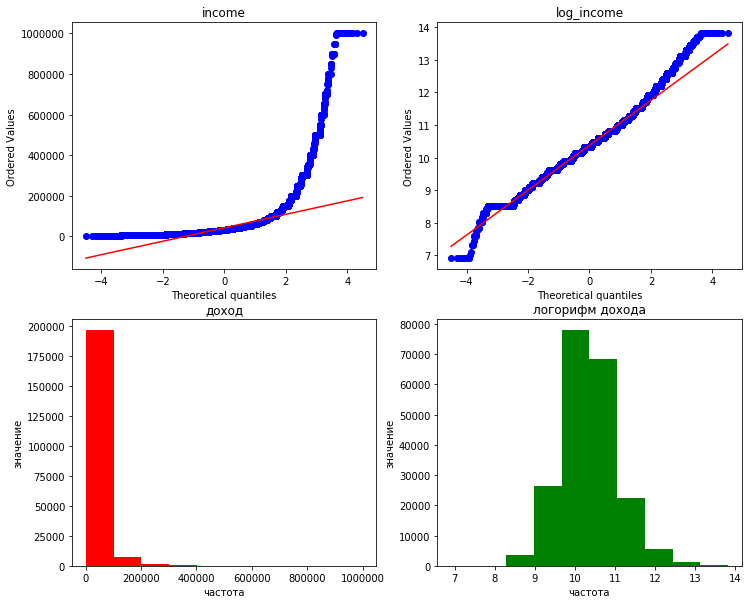

In [14]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
stats.probplot(data.income, dist="norm", plot=plt) # Q-Q график для income 
plt.title('income')
plt.subplot(2,2,2)
stats.probplot(np.log(data.income), dist="norm", plot=plt) # Q-Q график для age
plt.title('log_income')
plt.subplot(2,2,3)
plt.hist(data.income, color='red')
plt.title('доход')
plt.xlabel('частота')
plt.ylabel('значение')
plt.subplot(2,2,4)
plt.hist(np.log(data.income), color='green')
plt.title('логорифм дохода')
plt.xlabel('частота')
plt.ylabel('значение')
plt.show()

Q-Q график показывает, что логорифмирование признака income позволяет получить нормальное распределение.
Критерий Шапира-Уилка опустил в силу большой выборки (он работает на данных не превышающийх 5000 наблюдений)

Изменим данный признак на логарифм от income:

In [15]:
data['log_income'] = data.income.apply(lambda x: np.log(x)) # добавим признак log_income (логарифм дохода)
data.drop('income', axis=1, inplace=True) # удалим признак income (Доход)

**Обработка категориальных признаков и даты**

Признак application_dt (Дата подачи заявки) разделим на 2 признака: день месяца, месяц. Год вообще нет смысла рассматривать в силу того, что обучающая выборка заканчивается в конце 2014 года, а тестовая начинается только с 1 января 2015. Подобное разбиение может помочь в обнаружении временной цикличности.

In [16]:
data['day_application'] = data.application_dt.apply(lambda x: int(x[0:2])) # создаем признак (день подачи заявки)
data['month_application'] = data.application_dt.apply(lambda x: x[2:5]) # создаем признак (месяц подачи заявки)

data.drop('application_dt', axis=1, inplace=True) # удалим признак (Дата подачи заявки)

Попробуем кодировать категориальные переменные через LabelEncoder:

In [17]:
# функция кодирования заданных категориальных признаков
def Encoder_LabelEncoder(fields): # fields - список признаков
    encoder = LabelEncoder()
    for f in fields:
        data[f] = encoder.fit_transform(data[f])

In [18]:
# произведем кодирование для бинарных и категориальных
Encoder_LabelEncoder(['gender_cd', 'car_own_flg', 'car_type_flg', 'Air_flg'])
Encoder_LabelEncoder(['education_cd', 'day_application', 'month_application']) 

In [19]:
data[['gender_cd', 'car_own_flg', 'car_type_flg', 'Air_flg','education_cd', 'day_application', 'month_application']].head()
# data.dtypes

,gender_cd,car_own_flg,car_type_flg,Air_flg,education_cd,day_application,month_application
0,1,1,1,0,4,0,3
1,0,0,0,0,1,0,3
2,1,0,0,0,4,0,3
3,0,0,0,0,1,0,3
4,0,0,0,0,5,0,3


В дальнейшем, возможно произведем бининг (разбивка на карманы и прямое кодирование) для вещественных и некоторых целых признаков

**Коллинеарность признаков**

In [21]:
Corr_Total = data.ix[:, 1:].corr(method='pearson') # корреляция всех признаков
Corr_Cnt = data.corrwith(label.default_flg) # корреляция Цели от всех признаков

Корреляция с целевой меткой

In [22]:
Corr_Cnt.sort_values()

first_time_cd       -0.096150
region_rating       -0.089609
Air_flg             -0.063867
log_income          -0.052704
car_type_flg        -0.050112
good_work_flg       -0.047367
car_own_flg         -0.035595
age                 -0.025964
month_application   -0.005962
day_application     -0.004641
gender_cd            0.020321
home_address_cd      0.055765
work_address_cd      0.056023
out_request_cnt      0.065223
education_cd         0.077207
appl_rej_cnt         0.107177
SNA                  0.122386
Score_bki            0.170857
dtype: float64

Значение **целевой метки** относительно сильно коррелирует со следующими признаками:
* Score_bki (Скор балл по данным из бюро кредитных историй) = 17%
* SNA (Связь заявителя с клиентами) = 12%
* appl_rej_cnt (Количество отказанных прошлых заявок) = 11%
* first_time_cd (Давность наличия информации о заявителя) = -10%
* region_rating (Рейтинг региона) = -9%
* education_cd (Образование) = 8%
* out_request_cnt (Количество запросов в бюро) = 6.5%

Коллинеарность признаков:

In [23]:
max_corr = pd.DataFrame(Corr_Total.apply(lambda x : np.max(list(filter(lambda x: x!=1., x))), axis = 1))
max_corr.columns = ['max']
max_corr.sort_values(by = 'max', ascending = False).head()

,max
home_address_cd,0.740874
work_address_cd,0.740874
car_own_flg,0.700206
car_type_flg,0.700206
log_income,0.367215


* Домашний адрес сильно коррелирует с рабочим адресом = 74%
* Наличия машины и Иномарка = 70%
* Доход заявителя и Наличие иномарки 31%

In [24]:
min_corr = pd.DataFrame(Corr_Total.min())
min_corr.columns = ['min']
min_corr.sort_values(by = 'min').head()

,min
first_time_cd,-0.543833
SNA,-0.543833
Air_flg,-0.179766
log_income,-0.139277
age,-0.134972


* Связь заявителя с клиентами и Давность наличия информации о заявителе = -54%
* Обазование и Доход заявителя = -21%
* Наличие загран паспорта и Связь заявителя с клиентами = -18%

**Матрица попарных корреляций**

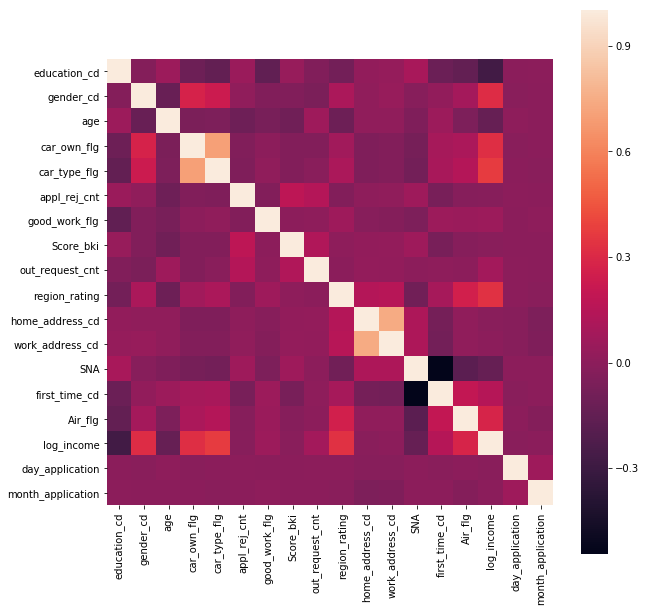

In [25]:
plt.figure(figsize=(10,10))
seaborn.heatmap(data.corr(), square=True);

Признаков достаточно мало и мы не будем выкидывать взаимозависимые, тем более в линейной модели используется регуляризация. Однако будем иметь ввиду, что признаки: наличие автомобиля и иномарки, а так же домашний и рабочий адрес сильно коррелируемы между собой

### 2. Разбивка и подготовка данных <a class='anchor' id='2'></a>
[в начало](#0)

In [20]:
data.head()

,education_cd,gender_cd,age,car_own_flg,car_type_flg,appl_rej_cnt,good_work_flg,Score_bki,out_request_cnt,region_rating,home_address_cd,work_address_cd,SNA,first_time_cd,Air_flg,log_income,day_application,month_application
0,4,1,27,1,1,0,0,-1.917831,0,40,2,3,1,4,0,10.373491,0,3
1,1,0,26,0,0,0,0,-1.153144,2,60,2,3,2,1,0,10.819778,0,3
2,4,1,35,0,0,0,1,-1.732810,0,40,1,2,4,3,0,9.903488,0,3
3,1,0,35,0,0,0,1,-2.552133,2,20,2,3,1,3,0,11.289782,0,3
4,5,0,24,0,0,0,0,-1.914581,1,50,2,3,1,2,0,10.203592,0,3


In [21]:
X = data[:180816]
X_test = data[180816:]
y = label.default_flg.values
print('Train data:{}, Train labels:{}'.format(X.shape, label.default_flg.shape))
print ('Test data:{}'.format(X_test.shape))

Train data:(180816, 18), Train labels:(180816,)
Test data:(24480, 18)


In [22]:
'''Перемешивание выборки'''
X,y = shuffle(X,y)

Разобьем с перемешиванием обучающую выборку и целевые метки на обучение и валидацию:

In [23]:
1-70668/110148 # доля валидационной выборки (1-validate/train)

0.3584268438827759

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3584)
print('X_train:{}, y_train:{}'.format(X_train.shape, y_train.shape))
print('X_valid:{}, y_valid:{}'.format(X_valid.shape, y_valid.shape))

X_train:(116011, 18), y_train:(116011,)
X_valid:(64805, 18), y_valid:(64805,)


In [25]:
data = None

### 3. Создание конвеера и обучение моделей <a class='anchor' id='3'></a>
[в начало](#0)

In [26]:
# для бинарных признаков
binary_data_columns = ['gender_cd', 'car_own_flg', 'car_type_flg', 'good_work_flg', 'Air_flg']
binary_data_indices = np.array([(column in binary_data_columns) for column in X_train.columns], dtype = bool)

In [27]:
# для целых признаков 
numeric_data_columns = ['education_cd','day_application','month_application','appl_rej_cnt','out_request_cnt',
                        'region_rating','home_address_cd','work_address_cd','SNA','first_time_cd'] 
numeric_data_indices = np.array([(column in numeric_data_columns) for column in X_train.columns], dtype = bool)

In [28]:
# для вещественных признаков        
float_data_columns = ['Score_bki','log_income','log_age'] 
float_data_indices = np.array([(column in float_data_columns) for column in X_train.columns], dtype = bool)

**Задание моделей**

In [29]:
model_1 = LogisticRegression(random_state = 0, class_weight='balanced')
model_2 = LinearSVC(random_state = 0, class_weight='balanced')
model_3 = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=100)
model_4 = GradientBoostingClassifier(random_state=0, n_estimators=100)
model_5 = XGBClassifier(n_estimators=100)

**Построение конвеера**

In [30]:
'''функция конвеер'''
def PipModel(model):
    pip = pipeline.Pipeline([
        # шаг 1: рзбивка на виды и предобработка
        ('feature_processing', pipeline.FeatureUnion([
            # шаг 1.1: вещественные признаки (выделение)
            ('binary_variables_processing', FunctionTransformer(lambda d: d[:, binary_data_indices])),  
            # шаг 1.2: целые признаки (выделение)
            ('numeric_variables_processing', pipeline.Pipeline([
                    ('selecting', FunctionTransformer(lambda d: d[:, numeric_data_indices])), 
#                     ('scaling', StandardScaler(with_mean = 0))
                    ('scaling', MinMaxScaler())
            ])),
            # шаг 1.3: вещественные признаки (выделение и стандартизация)
            ('float_variables_processing', pipeline.Pipeline([
                    ('selecting', FunctionTransformer(lambda d: d[:, float_data_indices])),
#                     ('scaling', StandardScaler(with_mean = 0))
                    ('scaling', MinMaxScaler())
            ]))
        ])),
        # шаг 2: обучение модели
        ('model_fitting', model)
    ])
    return pip

**Модель логистической регрессии:**

In [30]:
%%time
cv_1 = cross_val_score(PipModel(model_1), X, y, scoring='roc_auc', cv=5)
print('mean: {:.5f}, std: {:.5f}'.format(cv_1.mean(), cv_1.std()))

mean: 0.72347, std: 0.00441
Wall time: 11.3 s


**Модель линейного SVM:**

In [31]:
%%time
cv_2 = cross_val_score(PipModel(model_2), X, y, scoring='roc_auc', cv=5)
print('mean: {:.5f}, std: {:.5f}'.format(cv_2.mean(), cv_2.std()))

mean: 0.72342, std: 0.00441
Wall time: 6min 5s


**Модель cлучайного леса:**

In [32]:
%%time
cv_3 = cross_val_score(model_3, X, y, scoring='roc_auc', cv=5)
print('mean: {:.5f}, std: {:.5f}'.format(cv_3.mean(), cv_3.std()))

mean: 0.70610, std: 0.00478
Wall time: 3min 9s


**Модель градиентного бустинга sklearn:**

In [33]:
%%time
cv_4 = cross_val_score(model_4, X, y, scoring='roc_auc', cv=5)
print('mean: {:.5f}, std: {:.5f}'.format(cv_4.mean(), cv_4.std()))

mean: 0.73460, std: 0.00523
Wall time: 1min 44s


**Модель градиентного бустинга xgboost:**

In [34]:
%%time
cv_5 = cross_val_score(model_5, X, y, scoring='roc_auc', cv=5)
print('mean: {:.5f}, std: {:.5f}'.format(cv_5.mean(), cv_5.std()))

mean: 0.73361, std: 0.00494
Wall time: 1min 2s


### 4. Подбор параметров и анализ качества градиентного бустинга xgboost<a class='anchor' id='4'></a>
[в начало](#0)

Я буду использовать ансамблирование алгоритвом, а не одну модель XGB, в силу чего хочу подобрать наиболее достойные базовые алгоритмы стекинга

**Оптимальное количество деревьев и глубина**

In [32]:
%%time
'''подбор количества деревьев'''
estimators = list(range(30, 305, 5))
scoring_estimators = []

for i in estimators:
    clf = XGBClassifier(n_estimators=i)
    score = cross_val_score(clf, X, y, scoring='roc_auc', cv=3).mean()
    scoring_estimators.append(score)

Wall time: 51min 57s


In [33]:
%%time
'''подбор глубины деревьев'''
depth = list(range(1,11,1))
scoring_depth_1 = []
scoring_depth_2 = []

for i in depth:
    clf = XGBClassifier(max_depth=i, n_estimators=200)
    score = cross_val_score(clf, X, y, scoring='roc_auc', cv=3).mean()
    scoring_depth_1.append(score)
    clf = XGBClassifier(max_depth=i, n_estimators=300)
    score = cross_val_score(clf, X, y, scoring='roc_auc', cv=3).mean()
    scoring_depth_2.append(score)    

Wall time: 54min 58s


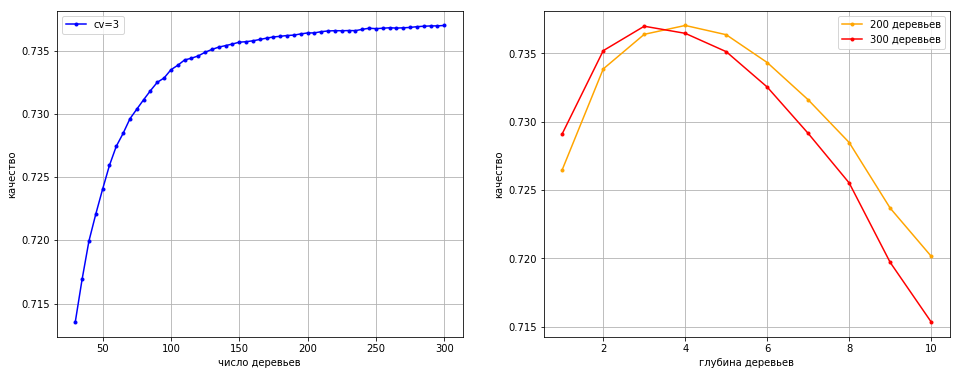

In [36]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(estimators, scoring_estimators, marker='.', color='blue', label='cv=3')
plt.grid(True)
plt.legend()
plt.xlabel('число деревьев')
plt.ylabel('качество')

plt.subplot(1,2,2)
plt.plot(depth, scoring_depth_1, marker='.', color='orange', label='200 деревьев')
plt.plot(depth, scoring_depth_2, marker='.', color='red', label='300 деревьев')
plt.grid(True)
plt.legend()
plt.xlabel('глубина деревьев')
plt.ylabel('качество')

plt.show()

**Подбор параметров по сетке**

In [44]:
param_grid = {'n_estimators': [200, 225, 250, 275, 300],
              'learning_rate': [0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1], 
              'max_depth': [1,2,3,4,5,6]}
clf = XGBClassifier() 
grid = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=5)

In [45]:
%%time
grid.fit(X,y)
print()


Wall time: 22h 28min 19s


In [46]:
'''Сохраним полученную модель-сетку'''
from sklearn.externals import joblib
# joblib.dump(grid, "Model_Grid_XGB.pkl")
grid = joblib.load("./Model_Grid_XGB.pkl")

['Model_Grid_XGB.pkl']

In [49]:
print(grid.best_params_, grid.best_score_)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 250} 0.7376463026051089


In [60]:
# grid_data = pd.DataFrame(grid.cv_results_)

In [149]:
'''id лучших моделей'''
id_200 = grid_data[grid_data.param_n_estimators==200].mean_test_score.idxmax()
id_225 = grid_data[grid_data.param_n_estimators==225].mean_test_score.idxmax()
id_250 = grid_data[grid_data.param_n_estimators==250].mean_test_score.idxmax()
id_275 = grid_data[grid_data.param_n_estimators==275].mean_test_score.idxmax()
id_300 = grid_data[grid_data.param_n_estimators==300].mean_test_score.idxmax()

'''параметры лучших моделей'''
params_200 = grid_data.params[id_200]
params_225 = grid_data.params[id_225]
params_250 = grid_data.params[id_250]
params_275 = grid_data.params[id_275]
params_300 = grid_data.params[id_300]

### 5. Ансамблирование алгоритмов посредством стекинга <a class='anchor' id='5'></a>
[в начало](#0)

Тестировать ансамбль будем на обучающей и валидационной выборке

In [163]:
%%time
m1 = XGBClassifier(**params_200)
m1.fit(X_train, y_train)
a = m1.predict_proba(X_valid)[:,1]
print('200 деревьев:',roc_auc_score(y_valid, a))

m2 = XGBClassifier(**params_225)
m2.fit(X_train, y_train)
a = m2.predict_proba(X_valid)[:,1]
print('225 деревьев:',roc_auc_score(y_valid, a))

m3 = XGBClassifier(**params_250)
m3.fit(X_train, y_train)
a = m3.predict_proba(X_valid)[:,1]
print('250 деревьев:',roc_auc_score(y_valid, a))

m4 = XGBClassifier(**params_275)
m4.fit(X_train, y_train)
a = m4.predict_proba(X_valid)[:,1]
print('275 деревьев:',roc_auc_score(y_valid, a))

m5 = XGBClassifier(**params_300)
m5.fit(X_train, y_train)
a = m5.predict_proba(X_valid)[:,1]
print('300 деревьев:',roc_auc_score(y_valid, a))

200 деревьев: 0.7338876940479592
225 деревьев: 0.7340484190034968
250 деревьев: 0.7341645680391437
275 деревьев: 0.7339874815375906
300 деревьев: 0.734529790626433
Wall time: 2min 21s


Проверим качество ансамбля из 5 моделей

In [166]:
models = [m1, m2, m3, m4, m5]
ens_model = LogisticRegression() # в качестве модели ансамбля выберем Лог.регрессию

In [167]:
%%time
'''ансамбль обучение/тест в отношении 75/25'''
s1 = DjStacking(models, ens_model)
s1.fit(X_train, y_train)
a = s1.predict(X_valid)
print(roc_auc_score(y_valid, a))

0.7323533790184251
Wall time: 1min 48s


In [168]:
%%time
'''ансамбль с Кросс-Валидацией на 3 фолда'''
s2 = DjStacking(models, ens_model)
s2.fit(X_train, y_train, p=-1)
a = s2.predict(X_valid)
print(roc_auc_score(y_valid, a))

0.7344059984633632
Wall time: 7min 1s


In [179]:
%%time
'''Варьируем число фолдов'''
s1 = DjStacking(models, ens_model)
E = []

for error in [0, 0.01, 0.05, 0.1, 0.5]:
    e = []
    for t in range(2, 11):
        s1.fit(X_train, y_train, p=-1, cv=t, err=error)
        a = s1.predict(X_valid)
        auc = roc_auc_score(y_valid, a)
        e.append(auc)
    E.append(e)

Wall time: 10h 9min 52s


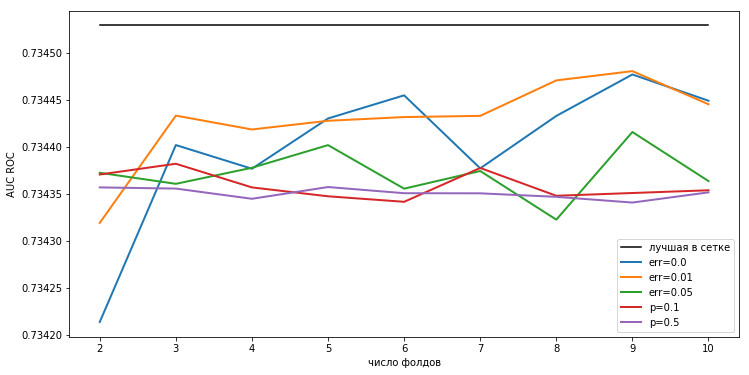

In [180]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(2,11), 0.734529790626433 + 0*np.arange(2,11), c='black', label='лучшая в сетке')
plt.plot(np.arange(2,11), E[0], label='err=0.0', lw=2)
plt.plot(np.arange(2,11), E[1], label='err=0.01', lw=2)
plt.plot(np.arange(2,11), E[2], label='err=0.05', lw=2)
plt.plot(np.arange(2,11), E[3], label='p=0.1', lw=2)
plt.plot(np.arange(2,11), E[4], label='p=0.5', lw=2)
plt.xlabel(u'число фолдов')
plt.ylabel('AUC ROC')
plt.legend()

Ансамблирование не позволило получить качество превышающее модель грудиентного бустинга с лучшими параметрами. Возможно это связано с тем, что ансамбль использует только один вид алгоритма (градиентный бустинг), однако качество остальных алгоритмов сильно уступает данному, в силу чего я буду использовать просто лучшую модель градиентного бустинга

### 6. Сравнение ROC кривых<a class='anchor' id='6'></a>
[в начало](#0)

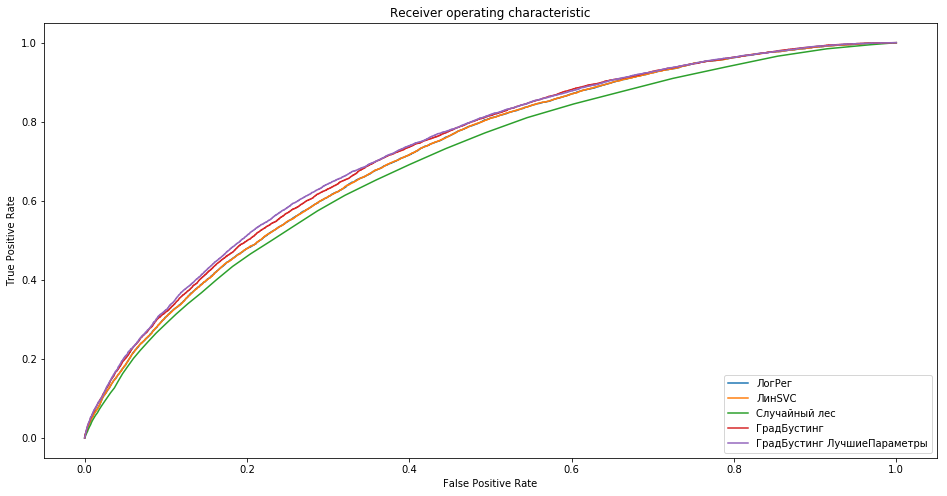

In [191]:
models = [PipModel(model_1), PipModel(model_2), model_3, model_4, grid.best_estimator_]
str_models = ['ЛогРег', 'ЛинSVC', 'Случайный лес', 'ГрадБустинг', 'ГрадБустинг ЛучшиеПараметры']

plt.figure(figsize=(16, 8)) 
for model, str_model in zip(models,str_models):
    model.fit(X_train, y_train)
    if (str_model in ['ЛинSVC']):
        pred_scr = model.decision_function(X_valid)
    else:
        pred_scr = model.predict_proba(X_valid)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_valid, pred_scr)
    plt.plot(fpr, tpr, label=str_model)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

**В качестве итоговой модели берем Градиентный бутсинг с лучшим параметром по сетке**

### 7. Получение прогнозов на тесте <a class='anchor' id='7'></a>
[в начало](#0)

Обучим модель на тестовых данных и загрузим результаты в kaggle

In [192]:
Model = grid.best_estimator_

In [193]:
%%time
Model.fit(X,y)

Wall time: 53.1 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [194]:
test_pd = Model.predict_proba(X_test)[:,1]

In [195]:
test_pd.shape

(24480,)

In [196]:
data = pd.read_csv('application_info.csv', index_col='id')
label = pd.read_csv('default_flg.csv') # подргузим id целевые метки

test_index  = data[data.sample_cd =='test'].sample_cd.index

In [197]:
test_index.shape

(24480,)

In [198]:
test_pd2 = pd.DataFrame(test_pd, columns=['score'], index=test_index)
test_pd2.to_csv('XGB_submission.csv')
print(test_pd2.shape)
test_pd2.head(2)

(24480, 1)


,score
id,
180817,0.080386
180818,0.138885


### 8. Пользовательские функции <a class='anchor' id='8'></a>                                                
[в начало](#0)

**функция визуализации параметров модели по сетке**

In [ ]:
def PrintGridParams(grid, param_grid, param_1, param_2, color='b'):

    values = grid.grid_scores_
    values = [values[k][1] for k in range(len(values))]
    values = np.round(values,4)
    size_1 = len(param_grid[param_1]) 
    size_2 = len(param_grid[param_2])
    values = np.reshape(values,(size_1,size_2)) # преобразование списка в матрицу

    xx = param_grid[param_2]
    yy = param_grid[param_1]
    
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(values)

    ax.set_xticks(range(len(xx)))
    ax.set_yticks(range(len(yy)))
    ax.set_xticklabels(xx)
    ax.set_yticklabels(yy)
    ax.set_xlabel(param_2)
    ax.set_ylabel(param_1)
    
    for i in range(len(xx)):
        for j in range(len(yy)):
            text = ax.text(i, j, values[j,i], ha='center', va='center', color=color)

    ax.set_title('Подбор параметров модели')
    fig.tight_layout()
    plt.show()

** Стекинг (ансамблирование) **

In [164]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

class DjStacking(BaseEstimator, ClassifierMixin):  
    """Стэкинг моделей scikit-learn"""

    def __init__(self, models, ens_model):
        """
        Инициализация
        models - базовые модели для стекинга
        ens_model - мета-модель
        """
        self.models = models
        self.ens_model = ens_model
        self.n = len(models)
        self.valid = None
        
    def fit(self, X, y=None, p=0.25, cv=3, err=0.001, random_state=None):
        """
        Обучение стекинга
        p - в каком отношении делить на обучение / тест
            если p = 0 - используем всё обучение!
        cv  (при p=0) - сколько фолдов использовать
        err (при p=0) - величина случайной добавки к метапризнакам
        random_state - инициализация генератора
            
        """
        if (p > 0): # делим на обучение и тест
            # разбиение на обучение моделей и метамодели
            train, valid, y_train, y_valid = train_test_split(X, y, test_size=p, random_state=random_state)
            
            # заполнение матрицы для обучения метамодели
            self.valid = np.zeros((valid.shape[0], self.n))
            for t, clf in enumerate(self.models):
                clf.fit(train, y_train)
                self.valid[:, t] = clf.predict_proba(valid)[:,1]
                
            # обучение метамодели
            self.ens_model.fit(self.valid, y_valid)
            
        else: # используем всё обучение
            
            # для регуляризации - берём случайные добавки
            self.valid = err*np.random.randn(X.shape[0], self.n)
            
            for t, clf in enumerate(self.models):
                # это oob-ответы алгоритмов
                self.valid[:, t] += cross_val_predict(clf, X, y, cv=cv, method='predict_proba')[:,1]
                # но сам алгоритм надо настроить
                clf.fit(X, y)
            
            # обучение метамодели
            self.ens_model.fit(self.valid, y)  
            

        return self
    


    def predict(self, X, y=None):
        """
        Работа стэкинга
        """
        # заполение матрицы для мета-классификатора
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict_proba(X)[:,1]
        
        a = self.ens_model.predict_proba(X_meta)[:,1]
        
        return (a)

### [в начало](#0)